# WSI - Ćwiczenie 5

*Autor: Maksymilian Nowak*

### Cel ćwiczenia

Celem ćwiczenia jest zaimplementowanie algorytmu Q-learning z $\varepsilon$-zachłanną strategią losowania akcji. Algorytm należy zastosować do wytrenowania agenta rozwiązującego problemu *Cliff Walking* dostępnego w pakiecie `gymnasium`.

Należy zbadać wpływ współczynnika dyskontowania ($\lambda$) i szybkości uczenia ($\beta$) na działanie algorytmu.

## Implementacja algorytmu

Poniższy kod jest implementacją algorytmu Q-learning z epizodami oraz $\varepsilon$-zachłanną strategią wybierania akcji.

Oprócz standardowych hiperparametrów funkcja przyjmuje również parametr określający środowisko, w którym będzie trenowany agent. Dodatkowo domyślna wartość maksymalnej liczby kroków, jaką może wykonać algorytm, została ustawiona na 150.

In [1]:
import numpy as np

def q_learning(env, episodes, _lambda, beta, epsilon, t_max=150):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []
    steps = []
    for _ in range(episodes):
        # Ocena strategii
        sum_reward = 0
        step = 0

        # Właściwy algorytm
        state = env.reset()[0]
        done = False
        t = 0
        while t < t_max and not done:
            # Epsilon-zachłanna strategia
            if np.random.uniform() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])
            next, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            sum_reward += reward
            step += 1
            Q[state][action] += beta * (reward + _lambda * np.max(Q[next]) - Q[state][action])
            state = next
            t += 1
        else:
            # Zapisanie wyników
            rewards.append(sum_reward)
            steps.append(step)

    return Q, rewards, steps


### Testowanie działania algorytmu

Aby przetestować działanie algorytmu, zdefiniuję funkcję wykonującą uczenie się ze wzmocnieniem, przedstawiającą jego wyniki oraz generującą trzy wykresy:
- uproszczony schemat przedstawiający nauczone wartości Q dla planszy problemu *Cliff Walking* (z zaznaczonym najlepszym ruchem)
- Uzyskane wartości sumy nagród w kolejnych epizodach
- Liczbę kroków wykonanych przez algorytm w danym epizodzie

Testowanie przeprowadzę z następujacymi hiperparametrami:
- Liczba epizodów - 300
- Wartość współczynnika dyskontowania - 0,5
- Wartość współczynnika uczenia się - 0,5
- Wartość współczynnika $\varepsilon$ - 0,1
- Maksymalna liczba kroków - 150 (wartość domyślna)

Wyniki uczenia:
Minimalna nagroda: -744
Maksymalna nagroda: -13
Średnia nagroda: -62.50666666666667
Minimalna liczba kroków: 13
Maksymalna liczba kroków: 150
Średnia liczba kroków: 24.226666666666667


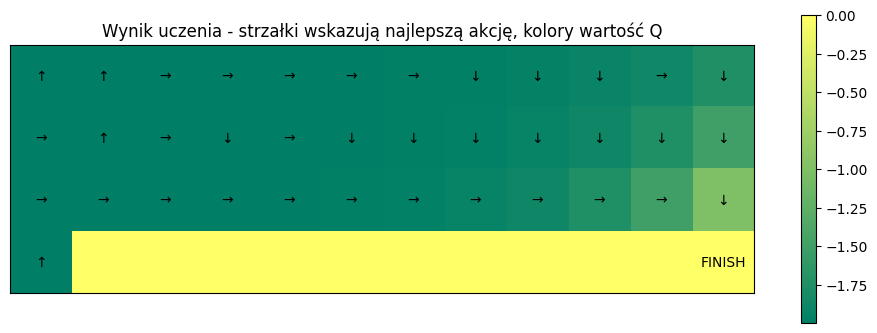

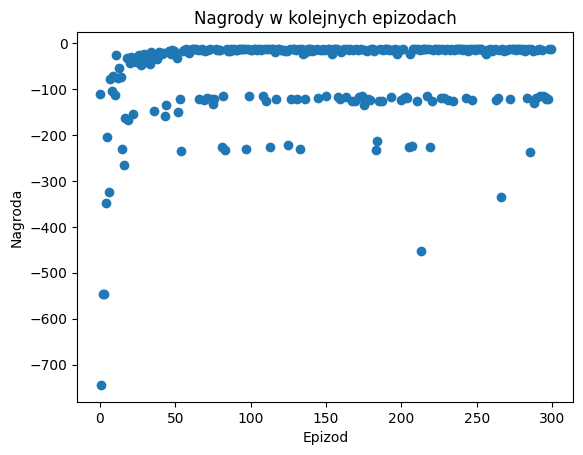

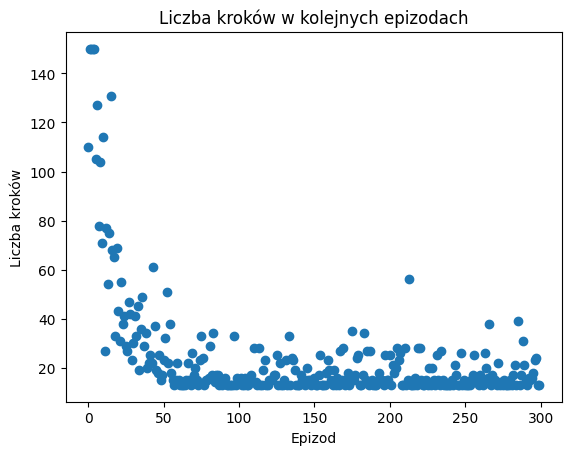

In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt

def learning_results(enviro, episodes, _lambda, beta, epsilon, t_max=150):
    Q, rewards, steps = q_learning(enviro, episodes, _lambda, beta, epsilon, t_max)

    # Pomocnicza funkcja do rysowania strzałek na wykresie z wartościami Q
    def arrows(direction, value):
        if value.all() == 0:
            return ' '
        if direction == '0':
            return '↑'
        elif direction == '1':
            return '→'
        elif direction == '2':
            return '↓'
        elif direction == '3':
            return '←'

    print('Wyniki uczenia:')
    print(f'Minimalna nagroda: {np.min(rewards)}')
    print(f'Maksymalna nagroda: {np.max(rewards)}')
    print(f'Średnia nagroda: {np.mean(rewards)}')
    print(f'Minimalna liczba kroków: {np.min(steps)}')
    print(f'Maksymalna liczba kroków: {np.max(steps)}')
    print(f'Średnia liczba kroków: {np.mean(steps)}')

    # Wartości Q
    heatmap = np.max(Q, axis=1).reshape((4, 12))
    plt.figure(figsize=(12, 4))
    plt.imshow(heatmap, cmap='summer', interpolation='nearest')
    for y in range(4):
        for x in range(12):
            q_value = Q[y * 12 + x]
            plt.text(x, y, arrows(str(np.argmax(q_value)), q_value), color='black', ha='center', va='center')
    plt.annotate('FINISH', xy=(11.5, 3.5), xytext=(11, 3), color='black', ha='center', va='center')
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.title('Wynik uczenia - strzałki wskazują najlepszą akcję, kolory wartość Q')
    plt.show()

    # Nagrody i liczba kroków
    plt.scatter(range(len(rewards)), rewards)
    plt.xlabel('Epizod')
    plt.ylabel('Nagroda')
    plt.title('Nagrody w kolejnych epizodach')
    plt.show()

    plt.scatter(range(len(steps)), steps)
    plt.xlabel('Epizod')
    plt.ylabel('Liczba kroków')
    plt.title('Liczba kroków w kolejnych epizodach')
    plt.show()

env = gym.make('CliffWalking-v0')

learning_results(env, 300, 0.5, 0.5, 0.1)

Można zauważyć, że algorytm działa poprawnie - wraz z kolejnymi epizodami, wartości nagród rosną, a kroków maleją. Sporadycznie można zauważyć niższe wartości nagród (będące zazwyczaj w przedziale od -100 do -250) - są one skutkiem zastosowania $\varepsilon$-zachłannej strategii. Pozwala ona na większą eksplorację obszaru obserwacji poprzez wybieranie losowej akcji zamiast "wyuczonej" przez algorytm z małym prawdopodobieństwem. Dobranie wartości parametru $\varepsilon$ ma wpływ na stopień tej eksploracji - np. jeśli wartość tego hiperparametru zostanie ustawiona na bardzo małą wartość (np. 0,01), jak na poniższym przykładzie:

Wyniki uczenia:
Minimalna nagroda: -645
Maksymalna nagroda: -13
Średnia nagroda: -26.856666666666666
Minimalna liczba kroków: 13
Maksymalna liczba kroków: 150
Średnia liczba kroków: 20.586666666666666


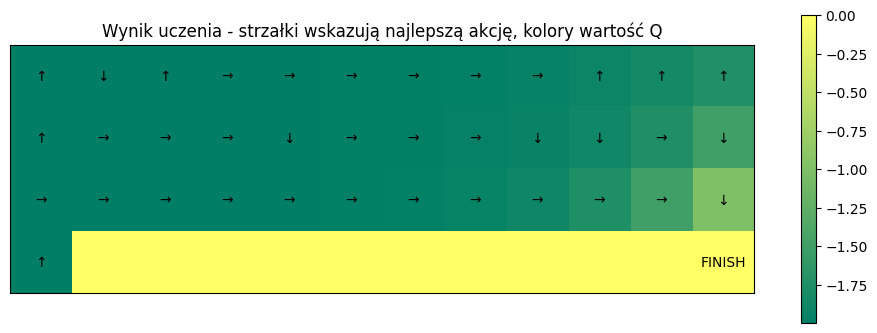

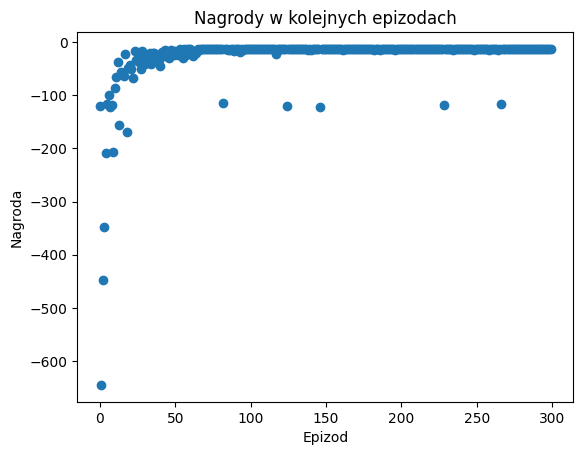

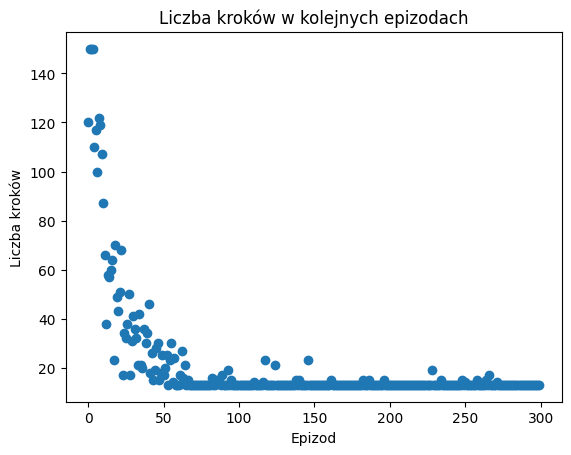

In [3]:
learning_results(env, 300, 0.5, 0.5, 0.01)

to można zauważyć, że wartości nagród są bardzo zbliżone, a eksploracja zachodzi znacznie rzadziej. Natomiast gdy wartość $\varepsilon$ będzie zbyt duża, jak na poniższym przykładzie:

Wyniki uczenia:
Minimalna nagroda: -2724
Maksymalna nagroda: -22
Średnia nagroda: -1074.48
Minimalna liczba kroków: 22
Maksymalna liczba kroków: 150
Średnia liczba kroków: 127.05


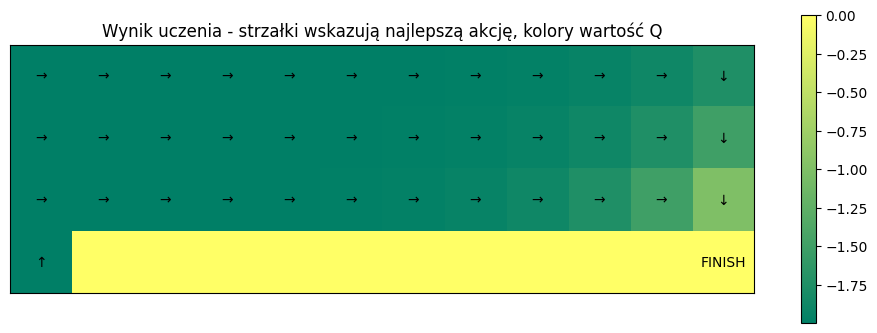

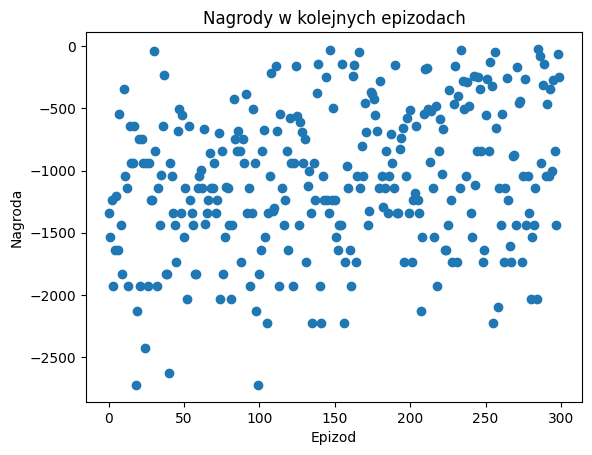

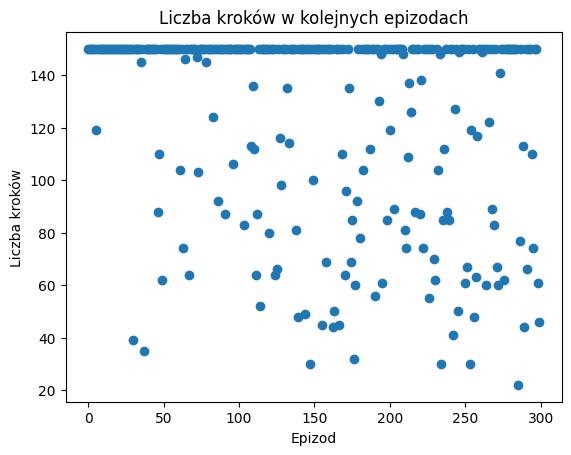

In [4]:
learning_results(env, 300, 0.5, 0.5, 0.8)

to algorytm będzie działał w sposób losowy. Na wykresie liczby kroków można nawet zauważyć, że w większości przypadków osiągała ona ustalony limit.

## Badanie wpływu parametrów na działanie algorytmu

Eksperymenty bedą przeprowadzane w następujący sposób:
1. Badane będą współczynniki dyskontowania i szybkości uczenia się (wartości obu hiperparametrów są z zakresu od 0,01 do 1, z krokiem co 0,05)
2. Dla każdej badanej wartości hiperparametru algorytm zostanie uruchomiony 50 razy z takimi samymi wartościami niebadanych parametrów, jak przy testowaniu działania algorytmu
3. Zostaną obliczone średnie wartości nagród i kroków dla każdego z epizodów, a także średnie wartości dla wszystkich zebranych wyników (bez podziału na epizody)
4. Dla każdej wartości hiperparametu wygenerowane zostaną dwa wykresy, przedstawiające zmianę średniej wartości nagrody i liczby kroków w kolejnych epizodach
5. Dodatkowo zostaną wygenerowane wartości dla średnich uzyskanych wyników, przedstawiające zmianę wartości wraz ze zmianą wartości hiperparametrów

### Współczynnik dyskontowania

Lambda: 0.01, średnia nagroda: -164.42806666666667, średnia liczba kroków: 145.72366666666667
Lambda: 0.05, średnia nagroda: -122.9318, średnia liczba kroków: 98.5712
Lambda: 0.1, średnia nagroda: -70.14546666666666, średnia liczba kroków: 28.968066666666665
Lambda: 0.15, średnia nagroda: -66.95726666666667, średnia liczba kroków: 27.509066666666666
Lambda: 0.2, średnia nagroda: -65.3422, średnia liczba kroków: 26.5804
Lambda: 0.25, średnia nagroda: -62.98126666666667, średnia liczba kroków: 25.876066666666667
Lambda: 0.3, średnia nagroda: -62.666466666666665, średnia liczba kroków: 25.409466666666667
Lambda: 0.35, średnia nagroda: -62.32606666666667, średnia liczba kroków: 24.983266666666665
Lambda: 0.4, średnia nagroda: -63.4512, średnia liczba kroków: 24.7488
Lambda: 0.45, średnia nagroda: -61.94766666666667, średnia liczba kroków: 24.426666666666666
Lambda: 0.5, średnia nagroda: -62.004, średnia liczba kroków: 24.1794
Lambda: 0.55, średnia nagroda: -61.4646, średnia liczba kroków: 

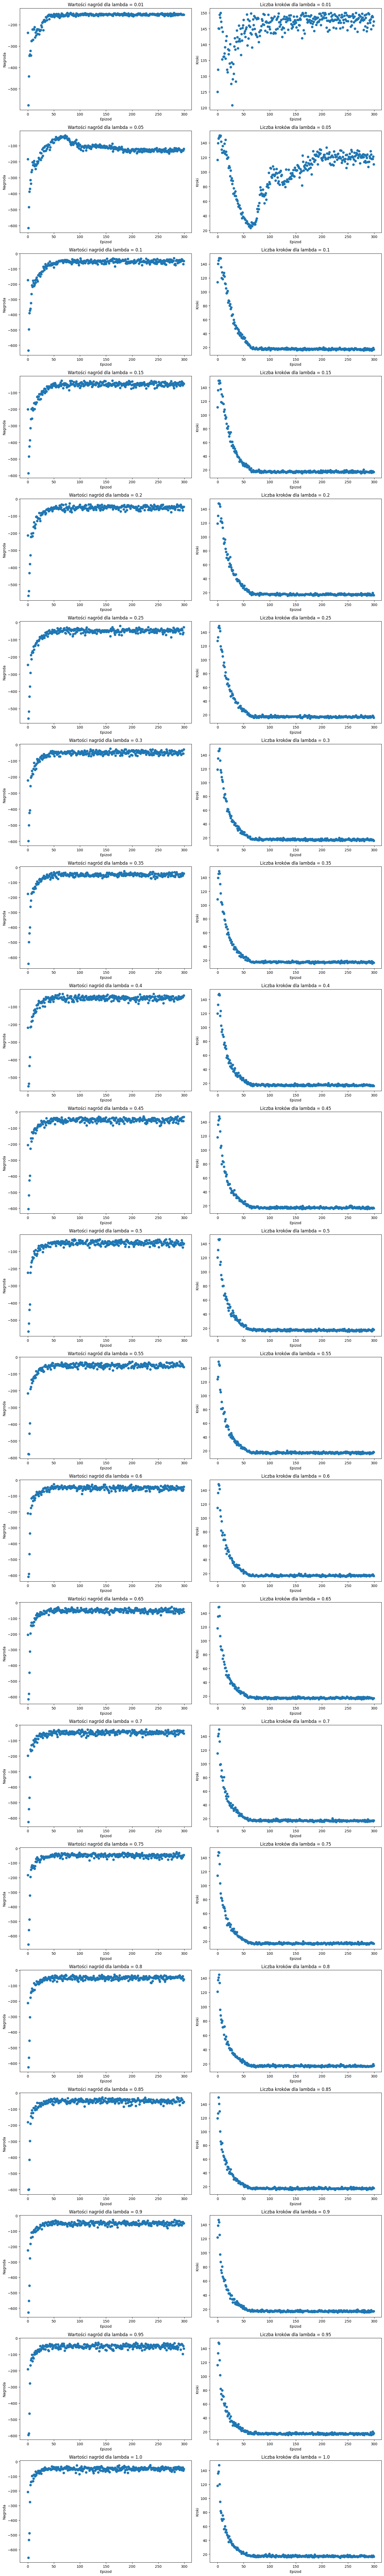

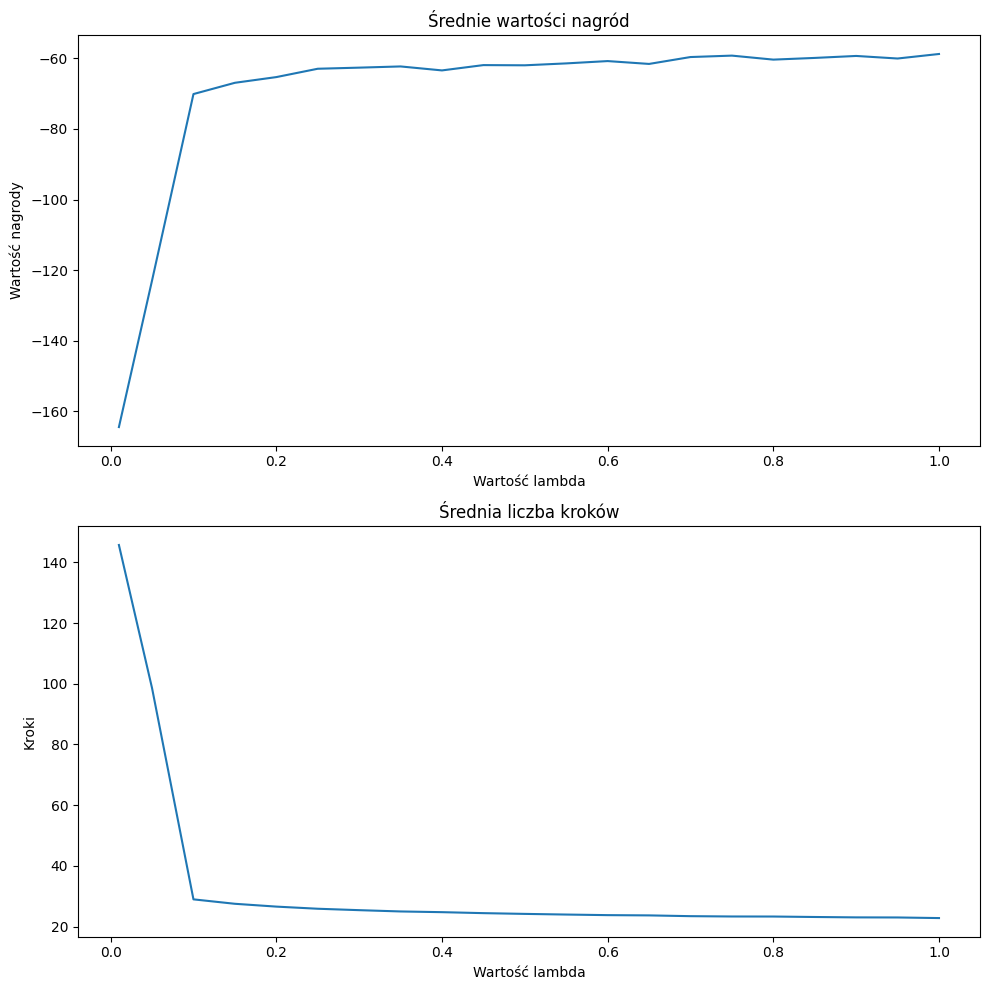

In [5]:
import matplotlib.pyplot as plt

def plot_lambda(values):
    rewards = []
    steps = []
    fig1, ax1 = plt.subplots(21, 2, figsize=(15, 100))
    for _lambda in values:
        lambda_rewards = []
        lambda_steps = []
        for _ in range(50):
            _, r, s = q_learning(env, 300, _lambda, 0.5, 0.1)
            lambda_rewards.append(r)
            lambda_steps.append(s)
        # Wartości dla każdego epizodu
        avg_episode_rewards = np.mean(lambda_rewards, axis=0)
        avg_episode_steps = np.mean(lambda_steps, axis=0)
        ax1[values.index(_lambda)][0].scatter(range(len(avg_episode_rewards)), avg_episode_rewards)
        ax1[values.index(_lambda)][0].set_xlabel('Epizod')
        ax1[values.index(_lambda)][0].set_ylabel('Nagroda')
        ax1[values.index(_lambda)][0].set_title(f'Wartości nagród dla lambda = {_lambda}')
        ax1[values.index(_lambda)][1].scatter(range(len(avg_episode_steps)), avg_episode_steps)
        ax1[values.index(_lambda)][1].set_xlabel('Epizod')
        ax1[values.index(_lambda)][1].set_ylabel('Kroki')
        ax1[values.index(_lambda)][1].set_title(f'Liczba kroków dla lambda = {_lambda}')
        avg_reward = np.mean(lambda_rewards)
        avg_steps = np.mean(lambda_steps)
        print(f'Lambda: {_lambda}, średnia nagroda: {avg_reward}, średnia liczba kroków: {avg_steps}')
        rewards.append(avg_reward)
        steps.append(avg_steps)
    fig1.tight_layout()
    # Średnie wartości
    fig2, ax2 = plt.subplots(2, figsize=(10, 10))
    ax2[0].plot(values, rewards)
    ax2[0].set_xlabel('Wartość lambda')
    ax2[0].set_ylabel('Wartość nagrody')
    ax2[0].set_title('Średnie wartości nagród')
    ax2[1].plot(values, steps)
    ax2[1].set_xlabel('Wartość lambda')
    ax2[1].set_ylabel('Kroki')
    ax2[1].set_title('Średnia liczba kroków')
    fig2.tight_layout()
    plt.show()

plot_lambda([0.01] + [round(0.05 * i, 2) for i in range(1, 21)])

#### Wnioski

Zmiany wartości hiperparametru $\lambda$ zmieniały zachowanie algorytmu tylko dla małych wartości. Wartość 0,01 sprawiała, że algorytm nie uczył się optymalnej ścieżki, często też "spadał z klifu" (co sugerują wartości nagród powyżej -100). Przy wartości hiperparametru równej 0,05 wystąpiło nietypowe zjawisko - do ok. 50 epizodu algorytm uczył się coraz bardziej optymalnych ścieżek, jednak potem zaczynał spowrotem popełniać błędy, czy też spadać z klifu. Dla wartości $\lambda\ge0.1$ algorytm zachowywał się w bardzo podobny sposób - do ok. 50 kroku uczył się optymalnej ścieżki, a następnie ją regularnie wykorzystywał do rozwiązywania określonego w ćwiczeniu problemu. Od tego momentu zwiększanie parametru stopniowo poprawiało metryki, jednak różnice nie były aż tak zauważalne jak na początku przeprowadzanego eksperymentu.

### Współczynnik szybkości uczenia się

Beta: 0.01, średnia nagroda: -222.7952, średnia liczba kroków: 132.1112
Beta: 0.05, średnia nagroda: -138.84433333333334, średnia liczba kroków: 80.59933333333333
Beta: 0.1, średnia nagroda: -97.6204, średnia liczba kroków: 53.9482
Beta: 0.15, średnia nagroda: -83.61433333333333, średnia liczba kroków: 41.77693333333333
Beta: 0.2, średnia nagroda: -74.9116, średnia liczba kroków: 35.4832
Beta: 0.25, średnia nagroda: -70.6732, średnia liczba kroków: 31.7992
Beta: 0.3, średnia nagroda: -67.67766666666667, średnia liczba kroków: 29.285466666666668
Beta: 0.35, średnia nagroda: -64.59466666666667, średnia liczba kroków: 27.430066666666665
Beta: 0.4, średnia nagroda: -63.17666666666667, średnia liczba kroków: 26.09786666666667
Beta: 0.45, średnia nagroda: -62.419066666666666, średnia liczba kroków: 25.049866666666667
Beta: 0.5, średnia nagroda: -61.70993333333333, średnia liczba kroków: 24.188933333333335
Beta: 0.55, średnia nagroda: -60.47153333333333, średnia liczba kroków: 23.452133333333

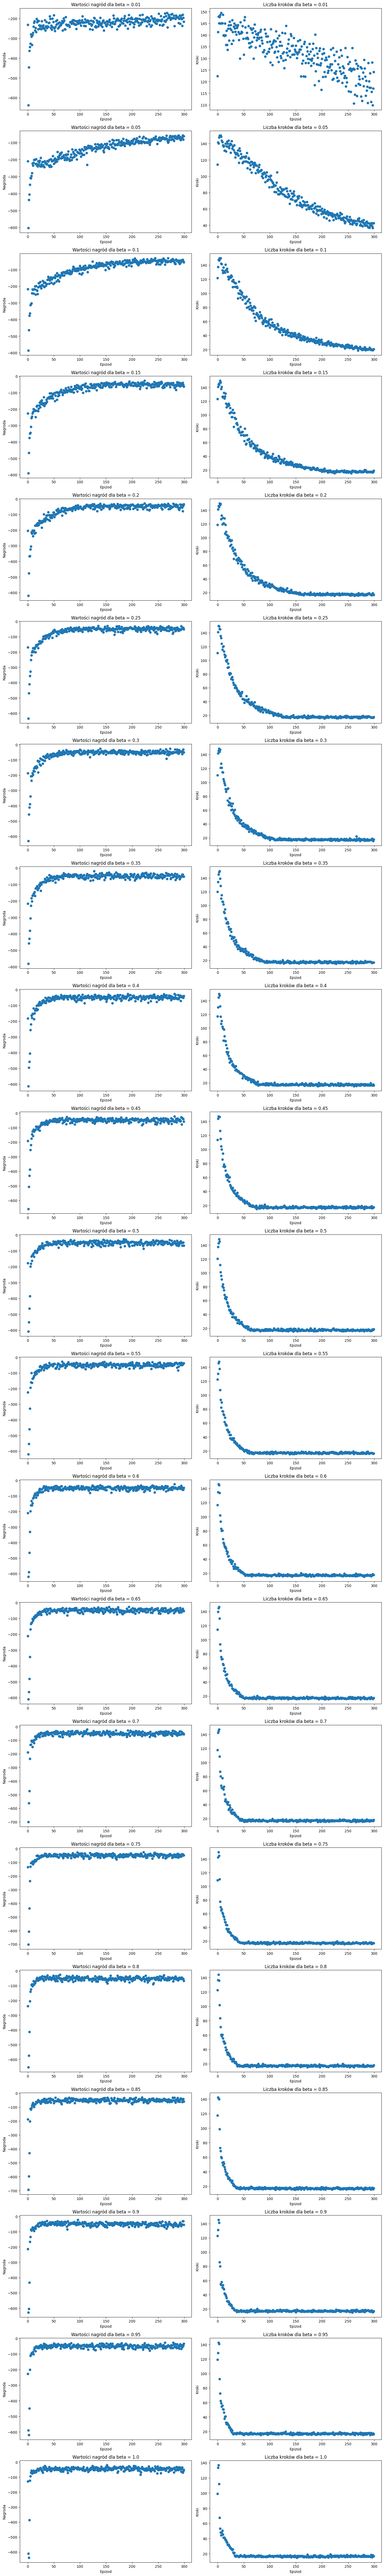

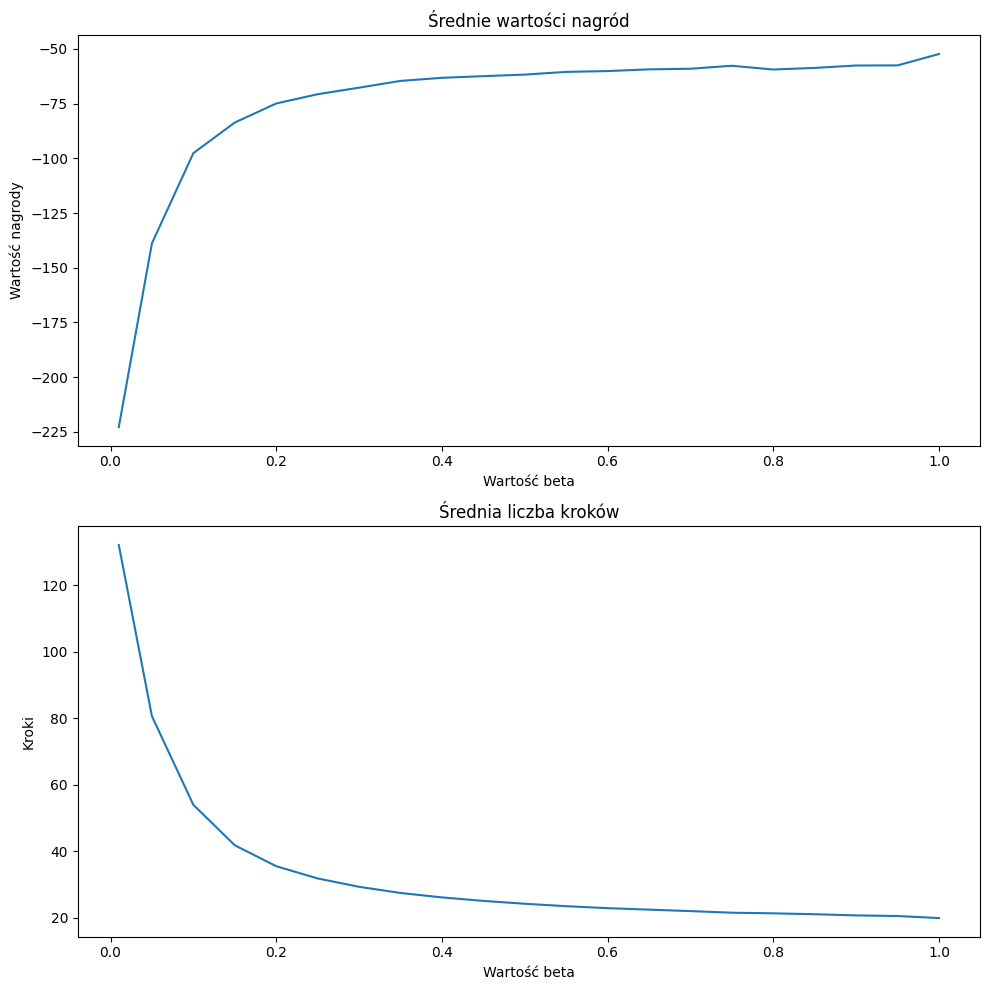

In [6]:
import matplotlib.pyplot as plt

def plot_beta(values):
    rewards = []
    steps = []
    fig1, ax1 = plt.subplots(21, 2, figsize=(15, 100))
    for beta in values:
        beta_rewards = []
        beta_steps = []
        for _ in range(50):
            _, r, s = q_learning(env, 300, 0.5, beta, 0.1)
            beta_rewards.append(r)
            beta_steps.append(s)
        # Wartości dla każdego epizodu
        avg_episode_rewards = np.mean(beta_rewards, axis=0)
        avg_episode_steps = np.mean(beta_steps, axis=0)
        ax1[values.index(beta)][0].scatter(range(len(avg_episode_rewards)), avg_episode_rewards)
        ax1[values.index(beta)][0].set_xlabel('Epizod')
        ax1[values.index(beta)][0].set_ylabel('Nagroda')
        ax1[values.index(beta)][0].set_title(f'Wartości nagród dla beta = {beta}')
        ax1[values.index(beta)][1].scatter(range(len(avg_episode_steps)), avg_episode_steps)
        ax1[values.index(beta)][1].set_xlabel('Epizod')
        ax1[values.index(beta)][1].set_ylabel('Kroki')
        ax1[values.index(beta)][1].set_title(f'Liczba kroków dla beta = {beta}')
        avg_reward = np.mean(beta_rewards)
        avg_steps = np.mean(beta_steps)
        print(f'Beta: {beta}, średnia nagroda: {avg_reward}, średnia liczba kroków: {avg_steps}')
        rewards.append(avg_reward)
        steps.append(avg_steps)
    fig1.tight_layout()
    # Średnie wartości
    fig2, ax2 = plt.subplots(2, figsize=(10, 10))
    ax2[0].plot(values, rewards)
    ax2[0].set_xlabel('Wartość beta')
    ax2[0].set_ylabel('Wartość nagrody')
    ax2[0].set_title('Średnie wartości nagród')
    ax2[1].plot(values, steps)
    ax2[1].set_xlabel('Wartość beta')
    ax2[1].set_ylabel('Kroki')
    ax2[1].set_title('Średnia liczba kroków')
    fig2.tight_layout()
    plt.show()

plot_beta([0.01] + [round(0.05 * i, 2) for i in range(1, 21)])

#### Wnioski

Zmiana hiperparametru $\beta$ miała bardziej znaczący wpływ na działania algorytmu. Stopniowe zwiększanie wartości parametru poprawiało uzyskiwane rezultaty - dla wartości $\beta\le0.1$ wzrastały uzyskiwane wartości nagród oraz malały liczby kroków. Dla większych wartości algorytm osiągał najlepsze możliwe dla określonego problemu metryki, jednak im większa wartość hiperparametru, tym szybciej to następowało - innymi słowy, algorytm uczył się szybciej.

## Końcowe wnioski

- Największy wpływ na działanie algorytmu Q-learning ma szybkość uczenia się
- Odpowiednio dobrany współczynnik dyskontowania może poprawić uzyskiwane wyniki
- Zmiany wartości hipeparametru $\varepsilon$ wpływają na to, jak bardzo eksplorowana jest przestrzeń obserwacji środowiska
    - Wybranie zbyt dużej wartości może jednak spowodować, że algorytm nie będzie wykorzystywał tego, czego się nauczył, a będzie częściej wykonywał losowe działania